In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [ ]:
%%bigquery unique_orders_newest --project fb-business-datasets
SELECT order_number, created_at, email, `interval`, Total_Net
FROM fb-business-datasets.ds_tables.unique_orders_newest

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
unique_orders_newest.created_at.max()

Timestamp('2024-07-03 00:34:39+0000', tz='UTC')

In [ ]:
## get wanted data from the unique_order_newest df
unique_orders = unique_orders_newest[unique_orders_newest['created_at'] < '2024-1-1']
print(unique_orders.describe().T)
unique_orders = unique_orders.sort_values('created_at')
print(unique_orders['created_at'].max())
## get the wanted client list from the unique_order df we just created
customers = unique_orders.email.unique()
unique_orders.head(5)

                 count            mean            std        min        25%  \
order_number  510739.0  1597994.578936  156005.753632  1327380.0  1463321.5   
interval      110974.0       68.535035      65.141645        0.0       18.0   
Total_Net     510739.0       55.075023      44.012463        7.7       26.0   

                    50%        75%        max  
order_number  1597789.0  1732419.5  1875581.0  
interval           49.0       99.0      362.0  
Total_Net          48.0       72.0     3428.0  
2023-12-31 23:59:51+00:00


,order_number,created_at,email,interval,Total_Net
661593,1327380,2023-01-01 00:01:31+00:00,rosacamacho.05@gmail.com,NaN,76.0
476327,1327381,2023-01-01 00:03:02+00:00,galeanogenesis@yahoo.com,NaN,28.0
86568,1327382,2023-01-01 00:03:34+00:00,maniehowley@optonline.net,NaN,90.0
539509,1327383,2023-01-01 00:04:00+00:00,lussarg@gmail.com,NaN,50.0
351655,1327384,2023-01-01 00:06:35+00:00,melgregory39@gmail.com,NaN,26.0


### CLV

#### **Model 1: Calculate CLV for each unique customer using the simple formula**

Customer Lifetime value (CLV) = Average Order Value * (Average) Order Frequency * (Average) Customer Lifespan = Total_Spend  * Customer Lifespan

In [ ]:
clv = pd.DataFrame(customers, columns=['email'])
recency = ((unique_orders.groupby('email')['created_at'].max() - unique_orders.groupby('email')['created_at'].min()).dt.days + 1) / 365
recency = recency.rename('Customer_Lifespan')
total_spend = unique_orders.groupby('email')['Total_Net'].sum()
total_spend = total_spend.rename('Total_Spend')
average_order_value = unique_orders.groupby('email')['Total_Net'].sum() / unique_orders.groupby('email')['order_number'].nunique()
average_order_value = average_order_value.rename('Average_Order_Value')
clv = pd.merge(clv, recency, on='email')
clv = pd.merge(clv, total_spend, on='email')
clv = pd.merge(clv, average_order_value, on='email')
clv['clv1'] = clv['Total_Spend'] * clv['Customer_Lifespan']

In [ ]:
## Rescale the clv1 to 0-1 for future use
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
clv['clv1_t'] = scaler.fit_transform(clv[['clv1']])*100
clv.sort_values('clv1', ascending=False).head(5)

,email,Customer_Lifespan,Total_Spend,Average_Order_Value,clv1,clv1_t
120818,glorieta73@hotmail.com,0.654795,33959.0,429.860759,22236.167123,100.000000
45054,n_fouani@hotmail.com,0.832877,11944.0,796.266667,9947.879452,44.737329
31658,gentlywefly@hotmail.com,0.556164,15360.0,512.000000,8542.684932,38.417913
19872,perisangelamoreira@gmail.com,0.923288,8245.5,374.795455,7612.968493,34.236809
9742,karanfile777@gmail.com,0.950685,7456.0,138.074074,7088.306849,31.877310


#### **Model 2: Calculate CLV for each unique customer using formula**

   

CLV = (AOV * Yearly Order Ratio) / (1 + Discount Rate - Yearly Order Ratio)

AOV: the average revenue per customer, which can be calculated by dividing the total revenue by the number of customers in a given period.

Yearly Order Ratio: this suggests that the data is adjusted to show a yearly ratio, focusing on how many orders are placed per month, on average, when extrapolated to a year.

Discount Rate: the interest rate used to discount future cash flows to their present value.


In [ ]:
## calculate the yearly_order_ratio defined above
## e.g. customer A bought 1 product in March and 2 products in April, then the "retention rate" is (1+2)/2/12
unique_orders['month'] = unique_orders['created_at'].dt.month
yearly_order_ratio = unique_orders.groupby('email')['order_number'].count() / unique_orders.groupby('email')['month'].nunique() / 12
yearly_order_ratio = yearly_order_ratio.rename('Yearly_Order_Ratio')
clv = pd.merge(clv, yearly_order_ratio, on='email')
discount_rate = 0.0
clv['clv2'] = (clv['Average_Order_Value'] * clv['Yearly_Order_Ratio']) / (1 + discount_rate - clv['Yearly_Order_Ratio'])

In [ ]:
## Rescale the clv2 to 0-1 for future use
clv['clv2_t'] = scaler.fit_transform(clv[['clv2']])*100
clv.sort_values('clv2', ascending=False).head(5)

,email,Customer_Lifespan,Total_Spend,Average_Order_Value,clv1,clv1_t,Yearly_Order_Ratio,clv2,clv2_t
120818,glorieta73@hotmail.com,0.654795,33959.0,429.860759,22236.167123,100.000000,0.822917,1997.588235,100.000000
31658,gentlywefly@hotmail.com,0.556164,15360.0,512.000000,8542.684932,38.417913,0.500000,512.000000,25.603822
106225,loredanafer@gmail.com,0.002740,3428.0,3428.000000,9.391781,0.042138,0.083333,311.636364,15.569892
267570,epicbeauty.sv@gmail.com,0.076712,1594.0,88.555556,122.279452,0.549814,0.750000,265.666667,13.267794
177378,karishmasabnani@yahoo.com,0.156164,4800.0,960.000000,749.589041,3.370940,0.208333,252.631579,12.615015


#### **Model 3: Calculate CLV for each unique customer using BG/NBD model**







In [ ]:
!pip install lifetimes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.2/584.2 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.6 MB/s eta 0:00:00


In [ ]:
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.utils import calibration_and_holdout_data

##### The idea of RFM

Recency : Last customer purchase date - first customer purchase date   

Age (T) : Last date in dataset - first customer purchase date   

Frequency : The number of dates the customer made repurchases on.

Monetary value : The average amount spent by a customer

In [ ]:
# # Calculate the recency using the formula: last customer purchase date - first customer purchase date (in month)
# recency = (unique_orders.groupby('email')['created_at'].max() - unique_orders.groupby('email')['created_at'].min()).dt.days / 365

# # Calculate the T/Age using the formula: last date in dataset - first customer purchase date (in month)
# age = (unique_orders['created_at'].max() - unique_orders.groupby('email')['created_at'].min()).dt.days / 30

# # Calculate the frequency which is the number of dates the customer made repurchases on
# unique_orders['order_date'] = pd.to_datetime(unique_orders['created_at']).dt.date
# frequency = unique_orders.groupby('email')['order_date'].nunique() - 1

# # Calculate the monetary which is the average order value for each customer
# monetary = unique_orders.groupby('email')['Total_Net'].sum() / unique_orders.groupby('email')['order_number'].nunique()
# monetary = monetary.rename('Monetary')

In [ ]:
# # Create CLV df for further analysis
# clv = customer_features[['email']]
# clv = pd.merge(clv, recency, on='email')
# clv.rename(columns={'created_at': 'Recency'}, inplace=True)
# clv = pd.merge(clv, age, on='email')
# clv.rename(columns={'created_at': 'T'}, inplace=True)
# clv = pd.merge(clv, frequency, on='email')
# clv.rename(columns={'order_date': 'Frequency'}, inplace=True)
# clv = pd.merge(clv, monetary, on='email')
# clv.head(5)

In [ ]:
## That the result from using lifetimes package is the same as our calculations, so we can directly use package

unique_orders['order_date'] = unique_orders['created_at'].dt.date
summary = calibration_and_holdout_data(unique_orders, 'email', 'order_date',
                                       calibration_period_end = '2023-12-30', # training data
                                       observation_period_end = '2024-1-1')   # testing data
summary = summary.reset_index()
summary.head()

,email,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
0,+1508596smbak55@gmail.com,0.0,0.0,143.0,0.0,2.0
1,0-orange-braces@icloud.com,0.0,0.0,259.0,0.0,2.0
2,0.aliases.iambic@icloud.com,0.0,0.0,12.0,0.0,2.0
3,00.finned-abodes@icloud.com,0.0,0.0,117.0,0.0,2.0
4,00.scythe-spinier@icloud.com,0.0,0.0,159.0,0.0,2.0


In [ ]:
clv = pd.merge(clv, summary[['email', 'frequency_cal', 'recency_cal', 'T_cal']], on='email')
clv.head(5)

,email,Customer_Lifespan,Total_Spend,Average_Order_Value,clv1,clv1_t,Yearly_Order_Ratio,clv2,clv2_t,frequency_cal,recency_cal,T_cal
0,rosacamacho.05@gmail.com,0.002740,76.0,76.0,0.208219,0.000838,0.083333,6.909091,0.309577,0.0,0.0,363.0
1,galeanogenesis@yahoo.com,0.002740,28.0,28.0,0.076712,0.000246,0.083333,2.545455,0.091052,0.0,0.0,363.0
2,maniehowley@optonline.net,0.863014,114.0,57.0,98.383562,0.442350,0.083333,5.181818,0.223077,1.0,314.0,363.0
3,lussarg@gmail.com,0.736986,65.0,32.5,47.904110,0.215335,0.083333,2.954545,0.111539,1.0,268.0,363.0
4,melgregory39@gmail.com,0.002740,26.0,26.0,0.071233,0.000222,0.083333,2.363636,0.081947,0.0,0.0,363.0


##### BG-NBD Model

BG / NBD (Beta Geometric / Negative Binominal Distribution) = Expected Number of Transaction
Buy Till You Die

The BG/NBD Model probabilistically models two processes for the Expected Number of Transaction.   

Transaction Process (Buy) + Dropout Process (Till You Die)


In [ ]:
## fit the bgf model with frequency, recency, and T
bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(clv['frequency_cal'], clv['recency_cal'], clv['T_cal'])
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.219634,0.002263,0.215198,0.224069
alpha,114.989679,1.678066,111.700669,118.278689
a,0.821474,0.050648,0.722203,0.920744
b,1.933715,0.131281,1.676404,2.191026


##### Gamma Gamma Model

It is used to estimate how much profit a customer can generate on average per transaction.

It will output the Expected Average Profit. This means; The Expected Average Profit distribution will be modeled over the whole audience, and the Gamma Gamma Submodel will be conditionally giving us the Expected Average Profit for a person, taking into account the distribution of the whole audience, according to the characteristics of the person himself.

In [ ]:
## Important Assumption: there is no relationship between the monetary value and the purchase frequency
return_clv = clv[clv['frequency_cal']>0]
print('Percentage of Return Customers:' , return_clv.shape[0] / clv.shape[0] *100)
return_clv[['Average_Order_Value', 'frequency_cal']].corr()

Percentage of Return Customers: 17.059864716471196


,Average_Order_Value,frequency_cal
Average_Order_Value,1.000000,0.112782
frequency_cal,0.112782,1.000000


In [ ]:
## Notice that we can only use return customers to fit the ggf model
ggf = GammaGammaFitter(penalizer_coef=0.0) # if soesn't converge then enlarge the penalizer_coef
ggf.fit(return_clv['frequency_cal'], return_clv['Average_Order_Value'])
ggf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
p,25.593448,1.921028,21.828234,29.358662
q,4.490644,0.050470,4.391722,4.589566
v,8.280280,0.723547,6.862127,9.698433


##### CLV

In [ ]:
## calculate the annual clv
clv['clv3'] = ggf.customer_lifetime_value(bgf, clv['frequency_cal'], clv['recency_cal'], clv['T_cal'], clv['Average_Order_Value'], time = 12,
                                         discount_rate=0.0) # monthly discount rate ~ 12.7% annually, but let's ignore it now
clv.sort_values("clv3", ascending=False).head(5)

,email,Customer_Lifespan,Total_Spend,Average_Order_Value,clv1,clv1_t,Yearly_Order_Ratio,clv2,clv2_t,frequency_cal,recency_cal,T_cal,clv3
120818,glorieta73@hotmail.com,0.654795,33959.0,429.860759,22236.167123,100.000000,0.822917,1997.588235,100.000000,44.0,238.0,239.0,13991.355880
168511,vivianandreaj@gmail.com,0.454795,14527.0,1117.461538,6606.800000,29.711886,0.180556,246.220339,12.293949,12.0,166.0,186.0,10230.263454
45054,n_fouani@hotmail.com,0.832877,11944.0,796.266667,9947.879452,44.737329,0.138889,128.430108,6.395179,13.0,303.0,308.0,6485.044191
263575,contacto.probrands@gmail.com,0.260274,6029.0,1004.833333,1569.191781,7.056843,0.166667,200.966667,10.027708,5.0,94.0,124.0,4254.725697
162297,mariadeshon@outlook.com,0.520548,5814.0,969.000000,3026.465753,13.610470,0.100000,107.666667,5.355375,5.0,189.0,193.0,3767.656705


In [ ]:
min(clv['clv3'])

0.5322686832045349

In [ ]:
## Rescale clv3 to 0-1 for future use
clv['clv3_t'] = scaler.fit_transform(clv[['clv3']])*100

##### Predict the number of purchases in each month after the calibration period    
**Remember to change the number of days in months you want to predict**

In [ ]:
#### Important: Remember to change the number of days in months you want to predict ####

## expected purchase number in the 1st month after calibration period (2024 Jan)
clv["month_1_purc"] = bgf.predict(31, clv['frequency_cal'], clv['recency_cal'], clv['T_cal'])
## expected purchase number in the 2nd month after calibration period (2024 Feb)
clv["month_2_purc"] = bgf.predict(59, clv['frequency_cal'], clv['recency_cal'], clv['T_cal']) - clv['month_1_purc']
## expected purchase number in the 3rd month after calibration period (2024 Mar)
clv["month_3_purc"] = bgf.predict(90, clv['frequency_cal'], clv['recency_cal'], clv['T_cal']) - clv['month_1_purc'] - clv['month_2_purc']
## expected purchase number in the 4th month after calibration period (2024 Apr)
clv["month_4_purc"] = bgf.predict(120, clv['frequency_cal'], clv['recency_cal'], clv['T_cal']) - clv['month_1_purc'] - clv['month_2_purc'] - clv['month_3_purc']
## expected purchase number in the 5th month after calibration period (2024 May)
clv["month_5_purc"] = bgf.predict(151, clv['frequency_cal'], clv['recency_cal'], clv['T_cal']) - clv['month_1_purc'] - clv['month_2_purc'] - clv['month_3_purc'] - clv['month_4_purc']
## expected purchase number in the 6th month after calibration period (2024 Jun)
clv["month_6_purc"] = bgf.predict(181, clv['frequency_cal'], clv['recency_cal'], clv['T_cal']) - clv['month_1_purc'] - clv['month_2_purc'] - clv['month_3_purc'] - clv['month_4_purc'] - clv['month_5_purc']

##### Visualization of Frequency/Recency Matrix

<Axes: title={'center': 'Expected Number of Future Purchases for 1 Unit of Time,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

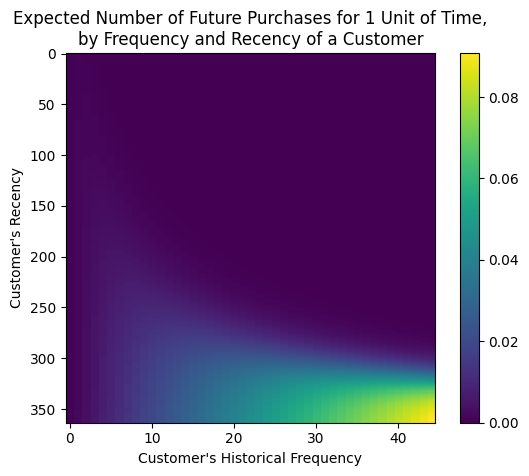

In [ ]:
from lifetimes.plotting import plot_frequency_recency_matrix
plot_frequency_recency_matrix(bgf)

<Axes: title={'center': 'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

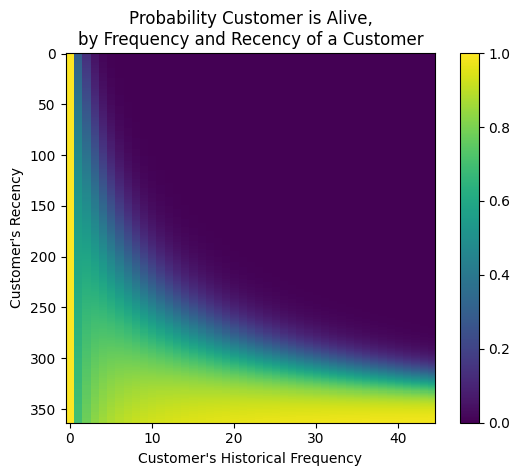

In [ ]:
from lifetimes.plotting import plot_probability_alive_matrix
plot_probability_alive_matrix(bgf)

##### Estimates the probability of still being active right after the calibration period

In [ ]:
clv['p_alive'] = bgf.conditional_probability_alive(clv['frequency_cal'], clv['recency_cal'], clv['T_cal'])
clv.sort_values(by='p_alive', ascending = False).head(5)

,email,Customer_Lifespan,Total_Spend,Average_Order_Value,clv1,clv1_t,Yearly_Order_Ratio,clv2,clv2_t,frequency_cal,...,T_cal,clv3,clv3_t,month_1_purc,month_2_purc,month_3_purc,month_4_purc,month_5_purc,month_6_purc,p_alive
0,rosacamacho.05@gmail.com,0.00274,76.0,76.0,0.208219,0.000838,0.083333,6.909091,0.309577,0.0,...,363.0,8.944256,0.060125,0.014080,0.012447,0.013499,0.012799,0.012967,0.012312,1.0
260791,jhammonsh@yahoo.com,0.00274,12.0,12.0,0.032877,0.000049,0.083333,1.090909,0.018210,0.0,...,126.0,16.255641,0.112383,0.027621,0.023946,0.025524,0.023812,0.023776,0.022278,1.0
260789,kayse81583@yahoo.com,0.00274,64.0,64.0,0.175342,0.000690,0.083333,5.818182,0.254946,0.0,...,126.0,16.255641,0.112383,0.027621,0.023946,0.025524,0.023812,0.023776,0.022278,1.0
260788,rochelle135@hotmail.com,0.00274,32.0,32.0,0.087671,0.000296,0.083333,2.909091,0.109262,0.0,...,126.0,16.255641,0.112383,0.027621,0.023946,0.025524,0.023812,0.023776,0.022278,1.0
260787,lee3alex@aol.com,0.00274,26.0,26.0,0.071233,0.000222,0.083333,2.363636,0.081947,0.0,...,126.0,16.255641,0.112383,0.027621,0.023946,0.025524,0.023812,0.023776,0.022278,1.0


<Axes: xlabel='p_alive', ylabel='Count'>

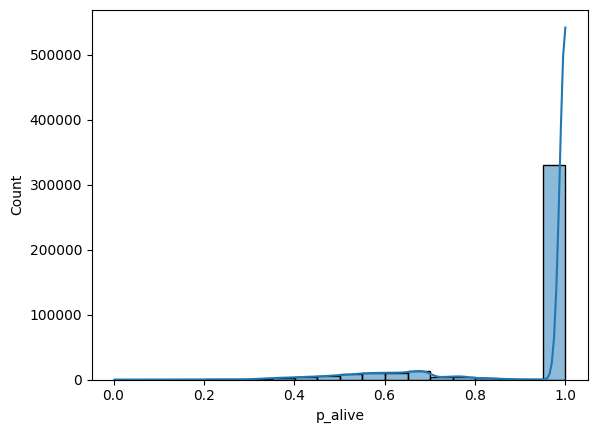

In [ ]:
sns.histplot(clv['p_alive'], kde = True)

##### Estimate the future average order value

In [ ]:
clv["expected_avg_order_value"] = ggf.conditional_expected_average_profit(clv['frequency_cal'], clv['Average_Order_Value'])
clv.sort_values("expected_avg_order_value", ascending=False).head(5)

,email,Customer_Lifespan,Total_Spend,Average_Order_Value,clv1,clv1_t,Yearly_Order_Ratio,clv2,clv2_t,frequency_cal,...,clv3,clv3_t,month_1_purc,month_2_purc,month_3_purc,month_4_purc,month_5_purc,month_6_purc,p_alive,expected_avg_order_value
24099,julianespitia07@gmail.com,0.304110,6113.0,2037.666667,1859.021918,8.360262,0.083333,185.242424,9.240260,2.0,...,1227.546545,8.770136,0.065126,0.056817,0.060859,0.057002,0.057088,0.053613,0.433973,1911.456753
202916,rojassmaria1999@gmail.com,0.200000,5778.0,1926.000000,1155.600000,5.196845,0.083333,175.090909,8.731887,2.0,...,2413.513138,17.246882,0.146312,0.125066,0.131566,0.121184,0.119562,0.110771,0.602731,1806.918947
109001,fernandohim2@gmail.com,0.219178,3456.0,1728.000000,757.479452,3.406425,0.083333,157.090909,7.830472,1.0,...,790.627691,5.647240,0.052856,0.046010,0.049191,0.045999,0.046007,0.043157,0.522022,1527.893647
168511,vivianandreaj@gmail.com,0.454795,14527.0,1117.461538,6606.800000,29.711886,0.180556,246.220339,12.293949,12.0,...,10230.263454,73.117434,1.057725,0.894083,0.931165,0.849658,0.831152,0.764051,0.871725,1105.585825
263575,contacto.probrands@gmail.com,0.260274,6029.0,1004.833333,1569.191781,7.056843,0.166667,200.966667,10.027708,5.0,...,4254.725697,30.407026,0.508176,0.426360,0.441334,0.400573,0.390100,0.357237,0.781967,979.763751


#### **Model 4: Calculate CLV for each unique customer using MBG/NBD model**

##### CLV

In [ ]:
## fit the modified bgf model with frequency, recency, and T
from lifetimes import ModifiedBetaGeoFitter
mbgnbd = ModifiedBetaGeoFitter(penalizer_coef=0.00)
mbgnbd.fit(clv['frequency_cal'], clv['recency_cal'], clv['T_cal'])

<lifetimes.ModifiedBetaGeoFitter: fitted with 398866 subjects, a: 0.85, alpha: 175.69, b: 0.76, r: 0.71>

In [ ]:
## calculate the annual clv
clv['clv4'] = ggf.customer_lifetime_value(mbgnbd, clv['frequency_cal'], clv['recency_cal'], clv['T_cal'], clv['Average_Order_Value'], time = 12,
                                         discount_rate=0.0) # monthly discount rate ~ 12.7% annually, but let's ignore it now
clv['clv4_t'] = scaler.fit_transform(clv[['clv4']])*100
clv.sort_values("clv4", ascending=False).head(5)

,email,Customer_Lifespan,Total_Spend,Average_Order_Value,clv1,clv1_t,Yearly_Order_Ratio,clv2,clv2_t,frequency_cal,...,month_1_purc,month_2_purc,month_3_purc,month_4_purc,month_5_purc,month_6_purc,p_alive,expected_avg_order_value,clv4,clv4_t
120818,glorieta73@hotmail.com,0.654795,33959.0,429.860759,22236.167123,100.000000,0.822917,1997.588235,100.000000,44.0,...,3.668281,3.116280,3.259292,2.985243,2.929776,2.700969,0.979702,428.720031,12370.672807,100.000000
168511,vivianandreaj@gmail.com,0.454795,14527.0,1117.461538,6606.800000,29.711886,0.180556,246.220339,12.293949,12.0,...,1.057725,0.894083,0.931165,0.849658,0.831152,0.764051,0.871725,1105.585825,9153.537700,73.990807
45054,n_fouani@hotmail.com,0.832877,11944.0,796.266667,9947.879452,44.737329,0.138889,128.430108,6.395179,13.0,...,0.882638,0.759384,0.803109,0.743123,0.735959,0.684024,0.935461,788.629782,5936.799121,47.984819
263575,contacto.probrands@gmail.com,0.260274,6029.0,1004.833333,1569.191781,7.056843,0.166667,200.966667,10.027708,5.0,...,0.508176,0.426360,0.441334,0.400573,0.390100,0.357237,0.781967,979.763751,3830.544417,30.956630
162297,mariadeshon@outlook.com,0.520548,5814.0,969.000000,3026.465753,13.610470,0.100000,107.666667,5.355375,5.0,...,0.443104,0.377507,0.395875,0.363504,0.357580,0.330363,0.870915,944.881911,3455.486562,27.924444


##### Predict the number of purchases in each month after th calibration period     

**Remember to change the number of days in months you want to predict**

In [ ]:
#### Important: Remember to change the number of days in months you want to predict ####

## expected purchase number in the 1st month after calibration period
clv["month_1_purc_m"] = mbgnbd.predict(31, clv['frequency_cal'], clv['recency_cal'], clv['T_cal'])
## expected purchase number in the 2nd month after calibration period
clv["month_2_purc_m"] = mbgnbd.predict(59, clv['frequency_cal'], clv['recency_cal'], clv['T_cal']) - clv['month_1_purc_m']
## expected purchase number in the 3rd month after calibration period
clv["month_3_purc_m"] = mbgnbd.predict(90, clv['frequency_cal'], clv['recency_cal'], clv['T_cal']) - clv['month_1_purc_m'] - clv['month_2_purc_m']
## expected purchase number in the 4th month after calibration period
clv["month_4_purc_m"] = mbgnbd.predict(120, clv['frequency_cal'], clv['recency_cal'], clv['T_cal']) - clv['month_1_purc_m'] - clv['month_2_purc_m'] - clv['month_3_purc_m']
## expected purchase number in the 5th month after calibration period
clv["month_5_purc_m"] = mbgnbd.predict(151, clv['frequency_cal'], clv['recency_cal'], clv['T_cal']) - clv['month_1_purc_m'] - clv['month_2_purc_m'] - clv['month_3_purc_m'] - clv['month_4_purc_m']
## expected purchase number in the 6th month after calibration period
clv["month_6_purc_m"] = mbgnbd.predict(181, clv['frequency_cal'], clv['recency_cal'], clv['T_cal']) - clv['month_1_purc_m'] - clv['month_2_purc_m'] - clv['month_3_purc_m'] - clv['month_4_purc_m'] - clv['month_5_purc_m']

##### Visualization of Frequency/Recency Matrix

<Axes: title={'center': 'Expected Number of Future Purchases for 1 Unit of Time,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

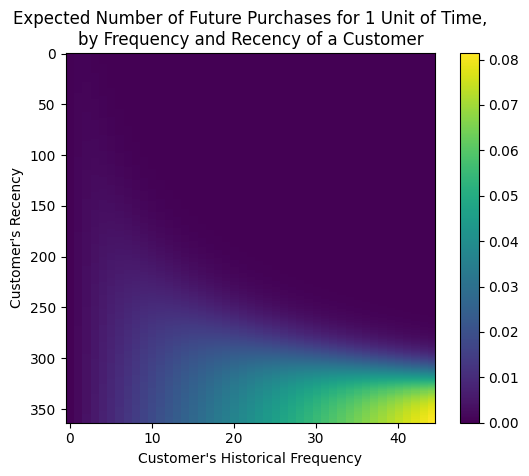

In [ ]:
plot_frequency_recency_matrix(mbgnbd)

<Axes: title={'center': 'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

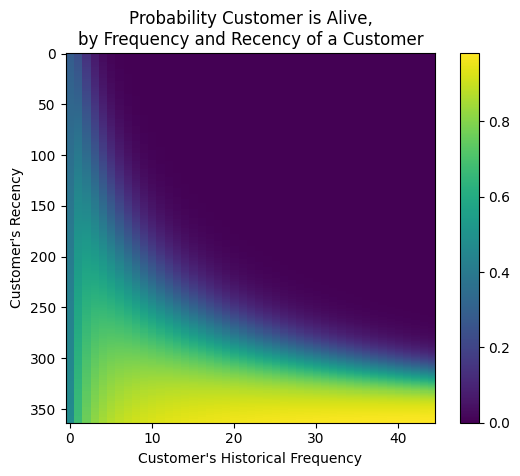

In [ ]:
plot_probability_alive_matrix(mbgnbd)

##### Estimates the probability of still being active right after the calibration period

<Axes: xlabel='p_alive_m', ylabel='Count'>

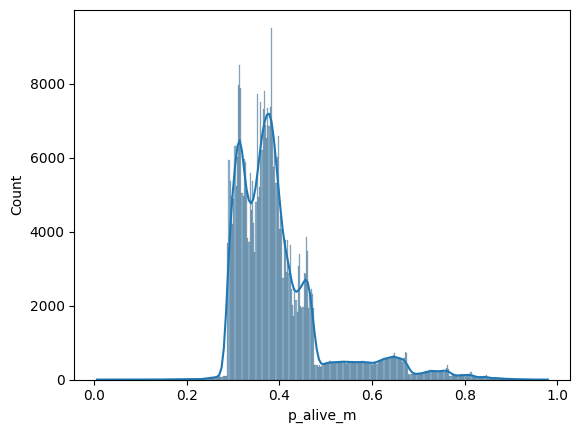

In [ ]:
clv['p_alive_m'] = mbgnbd.conditional_probability_alive(clv['frequency_cal'], clv['recency_cal'], clv['T_cal'])
sns.histplot(clv['p_alive_m'], kde = True)

#### Export Dataset to clv_23 in BigQuery

In [ ]:
clv['avg_clv'] = (clv['clv1_t'] + clv['clv2_t'] + clv['clv3_t'] + clv['clv4_t']) / 4

In [ ]:
clv.describe().T

,count,mean,std,min,25%,50%,75%,max
Customer_Lifespan,398866.0,0.055116,0.151855,0.002740,0.002740,0.002740,0.002740,0.997260
Total_Spend,398866.0,70.338645,109.835450,8.000000,26.000000,50.000000,78.000000,33959.000000
Average_Order_Value,398866.0,52.522809,36.799126,8.000000,26.000000,45.000000,69.000000,3428.000000
clv1,398866.0,10.824954,69.634602,0.021918,0.071233,0.142466,0.254795,22236.167123
clv1_t,398866.0,0.048583,0.313160,0.000000,0.000222,0.000542,0.001047,100.000000
Yearly_Order_Ratio,398866.0,0.086426,0.015807,0.083333,0.083333,0.083333,0.083333,0.822917
clv2,398866.0,5.017114,5.109647,0.727273,2.363636,4.363636,6.545455,1997.588235
clv2_t,398866.0,0.214829,0.255884,0.000000,0.081947,0.182104,0.291366,100.000000
frequency_cal,398866.0,0.266819,0.760380,0.000000,0.000000,0.000000,0.000000,44.000000
recency_cal,398866.0,18.999441,55.145653,0.000000,0.000000,0.000000,0.000000,362.000000


In [ ]:
project_id = 'fb-business-datasets'  # Google Cloud project ID
destination_table = 'fb-business-datasets.ds_tables.clv_23'  # destination table name in BigQuery
clv.to_gbq(destination_table, project_id=project_id, if_exists='replace')

100%|██████████| 1/1 [00:00<00:00, 329.95it/s]


#### **Predictions using Model 3 and Model 4**

##### Testing the accuracy of Model 3 and Model 4

In [ ]:
unique_orders_newest['order_date'] = unique_orders_newest['created_at'].dt.date
summary_2324 = calibration_and_holdout_data(unique_orders_newest, 'email', 'order_date',
                                       calibration_period_end = '2023-12-31',  # training data
                                       observation_period_end = '2024-7-2')   # testing data
summary_2324 = summary_2324.reset_index()

In [ ]:
## fit the bgf model with frequency, recency, and T
bgf_2324 = BetaGeoFitter(penalizer_coef=0.0)
bgf_2324.fit(summary_2324['frequency_cal'], summary_2324['recency_cal'], summary_2324['T_cal'])
bgf_2324.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.220599,0.002267,0.216156,0.225042
alpha,115.593560,1.681424,112.297969,118.889152
a,0.786055,0.048070,0.691838,0.880271
b,1.874223,0.126059,1.627147,2.121299


<Axes: title={'center': 'Actual Purchases in Holdout Period vs Predicted Purchases'}, xlabel='Purchases in calibration period', ylabel='Average of Purchases in Holdout Period'>

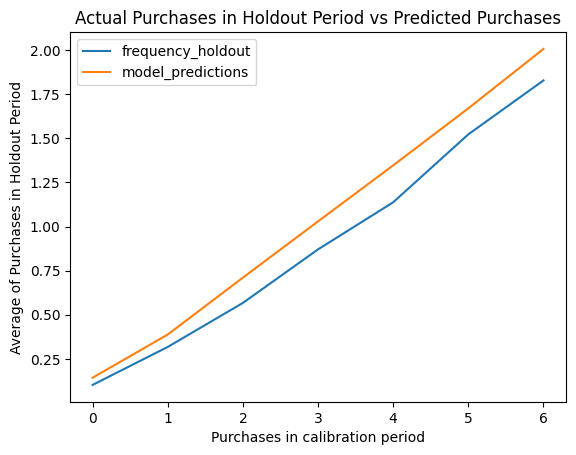

In [ ]:
## Check the accuracy of Model 3 using 2023 as calibration period and 2024 as holdout period
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases
plot_calibration_purchases_vs_holdout_purchases(bgf_2324, summary_2324)

In [ ]:
## fit the modified bgf model with frequency, recency, and T
mbgnbd_2324 = ModifiedBetaGeoFitter(penalizer_coef=0.0)
mbgnbd_2324.fit(summary_2324['frequency_cal'], summary_2324['recency_cal'], summary_2324['T_cal'])

<lifetimes.ModifiedBetaGeoFitter: fitted with 399765 subjects, a: 0.83, alpha: 176.62, b: 0.75, r: 0.72>

<Axes: title={'center': 'Actual Purchases in Holdout Period vs Predicted Purchases'}, xlabel='Purchases in calibration period', ylabel='Average of Purchases in Holdout Period'>

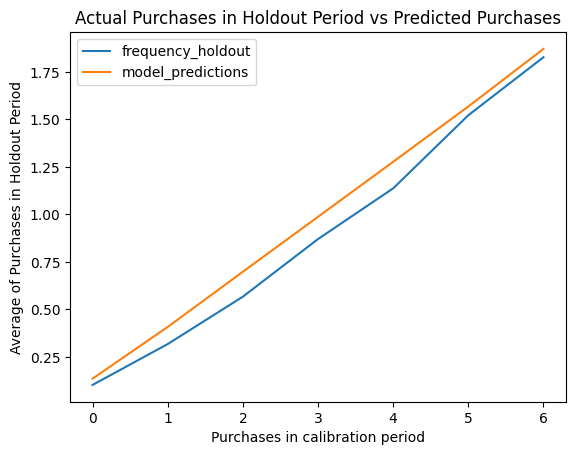

In [ ]:
## Check the accuracy of Model 4 using 2023 as calibration period and 2024 as holdout period
plot_calibration_purchases_vs_holdout_purchases(mbgnbd_2324, summary_2324)

##### Probability of alive based on newest data

In [ ]:
unique_orders_newest.created_at.max()

Timestamp('2024-07-03 00:34:39+0000', tz='UTC')

In [ ]:
summary_newest = calibration_and_holdout_data(unique_orders_newest, 'email', 'order_date',
                                       calibration_period_end = '2024-7-2',   # training data
                                       observation_period_end = '2024-7-4')   # testing data (cannot be the same as calibration)
summary_newest = summary_newest.reset_index()

In [ ]:
## fit the bgf model with frequency, recency, and T
bgf_newest = BetaGeoFitter(penalizer_coef=0.0)
bgf_newest.fit(summary_newest['frequency_cal'], summary_newest['recency_cal'], summary_newest['T_cal'])

<lifetimes.BetaGeoFitter: fitted with 582826 subjects, a: 1.04, alpha: 91.54, b: 1.97, r: 0.18>

In [ ]:
## fit the modified bgf model with frequency, recency, and T
mbgnbd_newest = ModifiedBetaGeoFitter(penalizer_coef=0.00)
mbgnbd_newest.fit(summary_newest['frequency_cal'], summary_newest['recency_cal'], summary_newest['T_cal'])

<lifetimes.ModifiedBetaGeoFitter: fitted with 582826 subjects, a: 1.03, alpha: 170.51, b: 0.71, r: 0.81>

In [ ]:
## Estimates the probability of still being active right after the calibration period using Model 3.
summary_newest['p_alive'] = bgf_newest.conditional_probability_alive(summary_newest['frequency_cal'], summary_newest['recency_cal'], summary_newest['T_cal'])

<Axes: xlabel='p_alive', ylabel='Count'>

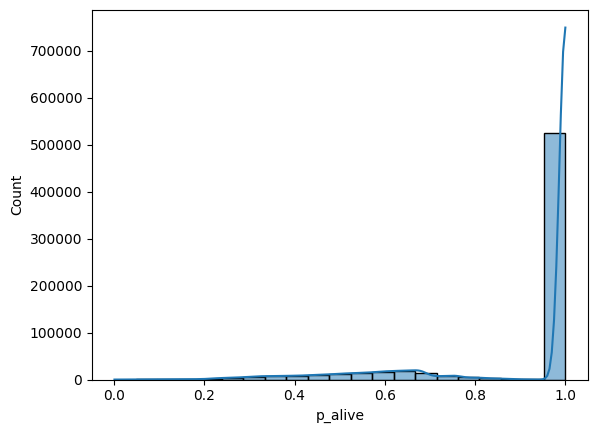

In [ ]:
sns.histplot(summary_newest['p_alive'], kde = True)

In [ ]:
## Estimates the probability of still being active right after the calibration period using Model 4.
summary_newest['p_alive_m'] = mbgnbd_newest.conditional_probability_alive(summary_newest['frequency_cal'], summary_newest['recency_cal'], summary_newest['T_cal'])

<Axes: xlabel='p_alive_m', ylabel='Count'>

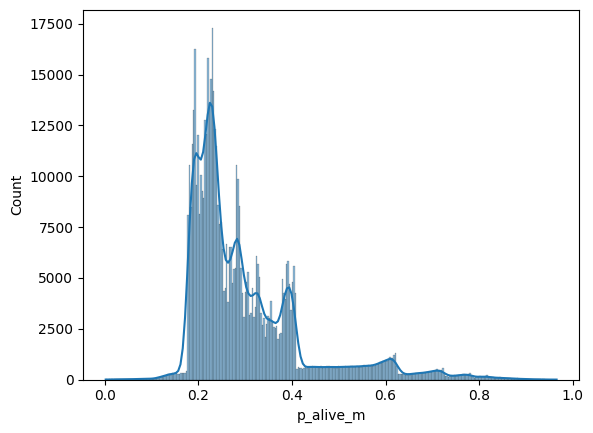

In [ ]:
sns.histplot(summary_newest['p_alive_m'], kde = True)

Predict the number of purchases in each month after the calibration period using the newest data

In [ ]:
#### Important: Remember to change the number of days in months you want to predict ####

## expected purchase number in the 1st month after calibration period (2024 Jul)
summary_newest["month_1_purc"] = bgf_newest.predict(31, summary_newest['frequency_cal'], summary_newest['recency_cal'], summary_newest['T_cal'])
## expected purchase number in the 2nd month after calibration period (2024 Aug)
summary_newest["month_2_purc"] = bgf_newest.predict(62, summary_newest['frequency_cal'], summary_newest['recency_cal'], summary_newest['T_cal']) - summary_newest['month_1_purc']
## expected purchase number in the 3rd month after calibration period (2024 Sep)
summary_newest["month_3_purc"] = bgf_newest.predict(92, summary_newest['frequency_cal'], summary_newest['recency_cal'], summary_newest['T_cal']) - summary_newest['month_1_purc']-summary_newest['month_2_purc']
## expected purchase number in the 4th month after calibration period (2024 Oct)
summary_newest["month_4_purc"] = bgf_newest.predict(123, summary_newest['frequency_cal'], summary_newest['recency_cal'], summary_newest['T_cal']) - summary_newest['month_1_purc']-summary_newest['month_2_purc']-summary_newest['month_3_purc']
## expected purchase number in the 5th month after calibration period (2024 Nov)
summary_newest["month_5_purc"] = bgf_newest.predict(153, summary_newest['frequency_cal'], summary_newest['recency_cal'], summary_newest['T_cal']) - summary_newest['month_1_purc']-summary_newest['month_2_purc']-summary_newest['month_3_purc']-summary_newest['month_4_purc']
## expected purchase number in the 6th month after calibration period (2024 Dec)
summary_newest["month_6_purc"] = bgf_newest.predict(184, summary_newest['frequency_cal'], summary_newest['recency_cal'], summary_newest['T_cal']) - summary_newest['month_1_purc']-summary_newest['month_2_purc']-summary_newest['month_3_purc']-summary_newest['month_4_purc']-summary_newest['month_5_purc']

In [ ]:
#### Important: Remember to change the number of days in months you want to predict ####

## expected purchase number in the 1st month after calibration period (2024 Jul)
summary_newest["month_1_purc_m"] = mbgnbd_newest.predict(31, summary_newest['frequency_cal'], summary_newest['recency_cal'], summary_newest['T_cal'])
## expected purchase number in the 2nd month after calibration period (2024 Aug)
summary_newest["month_2_purc_m"] = mbgnbd_newest.predict(62, summary_newest['frequency_cal'], summary_newest['recency_cal'], summary_newest['T_cal']) - summary_newest['month_1_purc_m']
## expected purchase number in the 3rd month after calibration period (2024 Sep)
summary_newest["month_3_purc_m"] = mbgnbd_newest.predict(92, summary_newest['frequency_cal'], summary_newest['recency_cal'], summary_newest['T_cal']) - summary_newest['month_1_purc_m']-summary_newest['month_2_purc_m']
## expected purchase number in the 4th month after calibration period (2024 Oct)
summary_newest["month_4_purc_m"] = mbgnbd_newest.predict(123, summary_newest['frequency_cal'], summary_newest['recency_cal'], summary_newest['T_cal']) - summary_newest['month_1_purc_m']-summary_newest['month_2_purc_m']-summary_newest['month_3_purc_m']
## expected purchase number in the 5th month after calibration period (2024 Nov)
summary_newest["month_5_purc_m"] = mbgnbd_newest.predict(153, summary_newest['frequency_cal'], summary_newest['recency_cal'], summary_newest['T_cal']) - summary_newest['month_1_purc_m']-summary_newest['month_2_purc_m']-summary_newest['month_3_purc_m']-summary_newest['month_4_purc_m']
## expected purchase number in the 6th month after calibration period (2024 Dec)
summary_newest["month_6_purc_m"] = mbgnbd_newest.predict(184, summary_newest['frequency_cal'], summary_newest['recency_cal'], summary_newest['T_cal']) - summary_newest['month_1_purc_m']-summary_newest['month_2_purc_m']-summary_newest['month_3_purc_m']-summary_newest['month_4_purc_m']-summary_newest['month_5_purc_m']

##### Expected Average Purchase value based on newest data

In [ ]:
customers_newest = unique_orders_newest.email.unique()
avg_order_value_newest = unique_orders_newest.groupby('email')['Total_Net'].sum() / unique_orders_newest.groupby('email')['order_number'].nunique()
avg_order_value_newest = avg_order_value_newest.rename('Average_Order_Value')
summary_newest = pd.merge(summary_newest, avg_order_value_newest, on='email', how='left')

In [ ]:
## Important Assumption: there is no relationship between the monetary value and the purchase frequency
return_summary_newest = summary_newest[summary_newest['frequency_cal']>0]
print('Percentage of Return Customers:' , return_summary_newest.shape[0] / summary_newest.shape[0] *100)
return_summary_newest[['Average_Order_Value', 'frequency_cal']].corr()

Percentage of Return Customers: 19.959816480390373


,Average_Order_Value,frequency_cal
Average_Order_Value,1.000000,0.114286
frequency_cal,0.114286,1.000000


In [ ]:
## Notice that we can only use return customers to fit the ggf model
ggf_newest = GammaGammaFitter(penalizer_coef = 0.0)
ggf_newest.fit(return_summary_newest['frequency_cal'], return_summary_newest['Average_Order_Value'])
ggf_newest.summary

,coef,se(coef),lower 95% bound,upper 95% bound
p,16.223938,0.574347,15.098217,17.349659
q,5.059636,0.045049,4.971340,5.147933
v,15.153492,0.680914,13.818901,16.488084


In [ ]:
## Estimate the average order value in the future
summary_newest["expected_avg_order_value"] = ggf_newest.conditional_expected_average_profit(summary_newest['frequency_cal'], summary_newest['Average_Order_Value'])
summary_newest.sort_values("expected_avg_order_value", ascending=True).head(5)

,email,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout,p_alive,p_alive_m,month_1_purc,month_2_purc,...,month_5_purc,month_6_purc,month_1_purc_m,month_2_purc_m,month_3_purc_m,month_4_purc_m,month_5_purc_m,month_6_purc_m,Average_Order_Value,expected_avg_order_value
18144,LisaGoodheart@mail.com,5.0,437.0,484.0,0.0,2.0,0.787141,0.782026,0.214922,0.206216,...,0.178281,0.177908,0.210629,0.202118,0.188117,0.187229,0.174750,0.174378,11.500000,13.838167
137855,cqffree@aol.com,3.0,204.0,370.0,0.0,2.0,0.481198,0.470542,0.100298,0.095778,...,0.081866,0.081442,0.100301,0.095676,0.088574,0.087726,0.081513,0.081005,12.000000,15.738446
85300,binkybink99@yahoo.com,2.0,67.0,298.0,0.0,2.0,0.287769,0.280399,0.048613,0.046266,...,0.039245,0.038966,0.050720,0.048154,0.044396,0.043809,0.040569,0.040194,10.666667,16.214745
545740,theroadlesstravelled@yahoo.com,2.0,93.0,372.0,0.0,2.0,0.278022,0.256818,0.039627,0.037999,...,0.032832,0.032766,0.040262,0.038484,0.035695,0.035417,0.032964,0.032810,10.666667,16.214745
581771,zelena.sofiya@gmail.com,2.0,157.0,318.0,0.0,2.0,0.490965,0.460672,0.078986,0.075344,...,0.064266,0.063907,0.080002,0.076109,0.070295,0.069478,0.064436,0.063927,10.666667,16.214745


#### Prediction VS Real

##### Prediction on the Total_Net of all active customers in 2023


In [ ]:
# ## calculate the expected total net using model 3 with 2023 data
# expected_total_month_1 = (clv['pur_month_1']*clv['expected_average_profit']).sum()
# expected_total_month_2 = (clv['pur_month_2']*clv['expected_average_profit']).sum()
# expected_total_month_3 = (clv['pur_month_3']*clv['expected_average_profit']).sum()
# expected_total_month_4 = (clv['pur_month_4']*clv['expected_average_profit']).sum()
# expected_total_month_5 = (clv['pur_month_5']*clv['expected_average_profit']).sum()
# expected_total_month_6 = (clv['pur_month_6']*clv['expected_average_profit']).sum()

In [ ]:
# ## calculate the expected total net using model 4 with 2023 data
# expected_total_month_1_m = (clv['pur_month_1_m']*clv['expected_average_profit']).sum()
# expected_total_month_2_m = (clv['pur_month_2_m']*clv['expected_average_profit']).sum()
# expected_total_month_3_m = (clv['pur_month_3_m']*clv['expected_average_profit']).sum()
# expected_total_month_4_m = (clv['pur_month_4_m']*clv['expected_average_profit']).sum()
# expected_total_month_5_m = (clv['pur_month_5_m']*clv['expected_average_profit']).sum()
# expected_total_month_6_m = (clv['pur_month_6_m']*clv['expected_average_profit']).sum()

In [ ]:
# ## Only keep the customers who is still alive
# alive_clv = clv[(clv['email'].isin(customers)) & (clv['p_alive'] >= 0.5)]
# ## calculate the expected total net using model 3 with 2023 data
# alive_expected_total_month_1 = (alive_clv['pur_month_1']*alive_clv['expected_average_profit']).sum()
# alive_expected_total_month_2 = (alive_clv['pur_month_2']*alive_clv['expected_average_profit']).sum()
# alive_expected_total_month_3 = (alive_clv['pur_month_3']*alive_clv['expected_average_profit']).sum()
# alive_expected_total_month_4 = (alive_clv['pur_month_4']*alive_clv['expected_average_profit']).sum()
# alive_expected_total_month_5 = (alive_clv['pur_month_5']*alive_clv['expected_average_profit']).sum()
# alive_expected_total_month_6 = (alive_clv['pur_month_6']*alive_clv['expected_average_profit']).sum()

In [ ]:
## The best model is to use Model 4 and the average p_alive in Model 3&4

## Only keep the customers who is still alive
alive_m_clv = clv[(clv['email'].isin(customers)) & ((clv['p_alive_m'] + clv['p_alive']) >= 1)]
## calculate the expected total net using model 4 with 2023 data
alive_expected_total_month_1_m = (alive_m_clv['month_1_purc_m']*alive_m_clv['expected_avg_order_value']).sum()
alive_expected_total_month_2_m = (alive_m_clv['month_2_purc_m']*alive_m_clv['expected_avg_order_value']).sum()
alive_expected_total_month_3_m = (alive_m_clv['month_3_purc_m']*alive_m_clv['expected_avg_order_value']).sum()
alive_expected_total_month_4_m = (alive_m_clv['month_4_purc_m']*alive_m_clv['expected_avg_order_value']).sum()
alive_expected_total_month_5_m = (alive_m_clv['month_5_purc_m']*alive_m_clv['expected_avg_order_value']).sum()
alive_expected_total_month_6_m = (alive_m_clv['month_6_purc_m']*alive_m_clv['expected_avg_order_value']).sum()

In [ ]:
min(clv["expected_avg_order_value"])

13.63998260143534

In [ ]:
import datetime

total_prediction = pd.DataFrame({
    'Date': datetime.datetime.utcnow(), # UTC time is used here
    'Calibration_Period': '2024-1-1',
    'Prediction_Period': ['2024-1','2024-2','2024-3','2024-4','2024-5','2024-6'],
    # 'Model3_Total': [expected_total_month_1,expected_total_month_2,expected_total_month_3,expected_total_month_4,expected_total_month_5,expected_total_month_6],
    # 'Alive_Model3_Total': [alive_expected_total_month_1,alive_expected_total_month_2,alive_expected_total_month_3,alive_expected_total_month_4,alive_expected_total_month_5,alive_expected_total_month_6],
    # 'Model4_Total': [expected_total_month_1_m,expected_total_month_2_m,expected_total_month_3_m,expected_total_month_4_m,expected_total_month_5_m,expected_total_month_6_m],
    'Alive_Model4_Total': [alive_expected_total_month_1_m,alive_expected_total_month_2_m,alive_expected_total_month_3_m,alive_expected_total_month_4_m,alive_expected_total_month_5_m,alive_expected_total_month_6_m],
    #'Real_Total': [real_total_month_1,real_total_month_2,real_total_month_3,real_total_month_4,real_total_month_5,real_total_month_6]
})
total_prediction

,Date,Calibration_Period,Prediction_Period,Alive_Model4_Total
0,2024-07-03 20:20:28.140515,2024-1-1,2024-1,928811.893564
1,2024-07-03 20:20:28.140515,2024-1-1,2024-2,795580.497456
2,2024-07-03 20:20:28.140515,2024-1-1,2024-3,838732.310284
3,2024-07-03 20:20:28.140515,2024-1-1,2024-4,774275.301896
4,2024-07-03 20:20:28.140515,2024-1-1,2024-5,765577.385050
5,2024-07-03 20:20:28.140515,2024-1-1,2024-6,710789.971450


In [ ]:
# total_prediction_vs_real['diff_model3'] = (total_prediction_vs_real['Model3_Total'] - total_prediction_vs_real['Real_Total']) / total_prediction_vs_real['Real_Total'] * 100
# total_prediction_vs_real['diff_alive_model3'] = (total_prediction_vs_real['Alive_Model3_Total'] - total_prediction_vs_real['Real_Total']) / total_prediction_vs_real['Real_Total'] * 100
# total_prediction_vs_real['diff_model4'] = (total_prediction_vs_real['Model4_Total'] - total_prediction_vs_real['Real_Total']) / total_prediction_vs_real['Real_Total'] * 100
# total_prediction_vs_real['diff_alive_model4'] = (total_prediction_vs_real['Alive_Model4_Total'] - total_prediction_vs_real['Real_Total']) / total_prediction_vs_real['Real_Total'] * 100

# total_prediction_vs_real['diff_avg_model3'] = ((total_prediction_vs_real['Model3_Total'] + total_prediction_vs_real['Alive_Model3_Total'])/2 - total_prediction_vs_real['Real_Total']) / total_prediction_vs_real['Real_Total'] * 100
# total_prediction_vs_real['diff_avg_model4'] = ((total_prediction_vs_real['Model4_Total'] + total_prediction_vs_real['Alive_Model4_Total'])/2 - total_prediction_vs_real['Real_Total']) / total_prediction_vs_real['Real_Total'] * 100

# total_prediction_vs_real['diff_avg_model'] = ((total_prediction_vs_real['Model3_Total'] + total_prediction_vs_real['Model4_Total'])/2 - total_prediction_vs_real['Real_Total']) / total_prediction_vs_real['Real_Total'] * 100
# total_prediction_vs_real['diff_avg_alive_model'] = ((total_prediction_vs_real['Alive_Model3_Total'] + total_prediction_vs_real['Alive_Model4_Total'])/2 - total_prediction_vs_real['Real_Total']) / total_prediction_vs_real['Real_Total'] * 100

# total_prediction_vs_real['diff_all_model'] = ((total_prediction_vs_real['Model3_Total'] + total_prediction_vs_real['Model4_Total'] + total_prediction_vs_real['Alive_Model3_Total'] + total_prediction_vs_real['Alive_Model4_Total'])/4 - total_prediction_vs_real['Real_Total']) / total_prediction_vs_real['Real_Total'] * 100

# total_prediction_vs_real

In [ ]:
# project_id = 'fb-business-datasets'  # Google Cloud project ID
# destination_table = 'fb-business-datasets.ds_tables.total_prediction'  # destination table name in BigQuery
# total_prediction.to_gbq(destination_table, project_id=project_id, if_exists='append')

##### Prediction on the Total_Net of each active customers in 2023

In [ ]:
clv.columns

Index(['email', 'Customer_Lifespan', 'Total_Spend', 'Average_Order_Value',
       'clv1', 'clv1_t', 'Yearly_Order_Ratio', 'clv2', 'clv2_t',
       'frequency_cal', 'recency_cal', 'T_cal', 'clv3', 'clv3_t',
       'month_1_purc', 'month_2_purc', 'month_3_purc', 'month_4_purc',
       'month_5_purc', 'month_6_purc', 'p_alive', 'expected_avg_order_value',
       'clv4', 'clv4_t', 'month_1_purc_m', 'month_2_purc_m', 'month_3_purc_m',
       'month_4_purc_m', 'month_5_purc_m', 'month_6_purc_m', 'p_alive_m',
       'avg_clv'],
      dtype='object')

In [ ]:
prediction_customer = pd.DataFrame({
    'Date': datetime.datetime.utcnow(), # UTC time is used here
    'Calibration_Period': '2024-1-1',
    'email': customers
})
prediction_customer = pd.merge(prediction_customer, clv[['email','expected_avg_order_value','p_alive','month_1_purc','month_2_purc','month_3_purc','month_4_purc',
                          'month_5_purc','month_6_purc','p_alive_m','month_1_purc_m','month_2_purc_m','month_3_purc_m','month_4_purc_m',
                          'month_5_purc_m','month_6_purc_m']], on='email',how='left')
# prediction_vs_real['avg_p_alive'] = (prediction_vs_real['p_alive'] + prediction_vs_real['p_alive_m']) / 2
prediction_customer['p_alive_01'] = np.where(prediction_customer['p_alive'] >= 0.5, 1, 0)
# prediction_vs_real['p_alive_m_01'] = np.where(prediction_vs_real['p_alive_m'] >= 0.5, 1, 0)
# prediction_vs_real['avg_p_alive_01'] = np.where(prediction_vs_real['avg_p_alive'] >= 0.5, 1, 0)

In [ ]:
## Prediction of Total_Net made by each customer using Model 3 and p_alive
prediction_customer['Model3_month_1_total'] = prediction_customer['p_alive_01'] * prediction_customer['expected_avg_order_value'] * prediction_customer['month_1_purc']
prediction_customer['Model3_month_2_total'] = prediction_customer['p_alive_01'] * prediction_customer['expected_avg_order_value'] * prediction_customer['month_2_purc']
prediction_customer['Model3_month_3_total'] = prediction_customer['p_alive_01'] * prediction_customer['expected_avg_order_value'] * prediction_customer['month_3_purc']
prediction_customer['Model3_month_4_total'] = prediction_customer['p_alive_01'] * prediction_customer['expected_avg_order_value'] * prediction_customer['month_4_purc']
prediction_customer['Model3_month_5_total'] = prediction_customer['p_alive_01'] * prediction_customer['expected_avg_order_value'] * prediction_customer['month_5_purc']
prediction_customer['Model3_month_6_total'] = prediction_customer['p_alive_01'] * prediction_customer['expected_avg_order_value'] * prediction_customer['month_6_purc']

In [ ]:
# ## Prediction of Total_Net made by each customer using Model 3 and avg_p_alive
# prediction_vs_real['Model3_month_1_avgp'] = prediction_vs_real['avg_p_alive_01'] * prediction_vs_real['expected_average_profit'] * prediction_vs_real['pur_month_1']
# prediction_vs_real['Model3_month_2_avgp'] = prediction_vs_real['avg_p_alive_01'] * prediction_vs_real['expected_average_profit'] * prediction_vs_real['pur_month_2']
# prediction_vs_real['Model3_month_3_avgp'] = prediction_vs_real['avg_p_alive_01'] * prediction_vs_real['expected_average_profit'] * prediction_vs_real['pur_month_3']
# prediction_vs_real['Model3_month_4_avgp'] = prediction_vs_real['avg_p_alive_01'] * prediction_vs_real['expected_average_profit'] * prediction_vs_real['pur_month_4']
# prediction_vs_real['Model3_month_5_avgp'] = prediction_vs_real['avg_p_alive_01'] * prediction_vs_real['expected_average_profit'] * prediction_vs_real['pur_month_5']
# prediction_vs_real['Model3_month_6_avgp'] = prediction_vs_real['avg_p_alive_01'] * prediction_vs_real['expected_average_profit'] * prediction_vs_real['pur_month_6']

In [ ]:
# ## Prediction of Total_Net made by each customer using Model 4 and p_alive
# prediction_vs_real['Model4_month_1'] = prediction_vs_real['p_alive_m_01'] * prediction_vs_real['expected_average_profit'] * prediction_vs_real['pur_month_1_m']
# prediction_vs_real['Model4_month_2'] = prediction_vs_real['p_alive_m_01'] * prediction_vs_real['expected_average_profit'] * prediction_vs_real['pur_month_2_m']
# prediction_vs_real['Model4_month_3'] = prediction_vs_real['p_alive_m_01'] * prediction_vs_real['expected_average_profit'] * prediction_vs_real['pur_month_3_m']
# prediction_vs_real['Model4_month_4'] = prediction_vs_real['p_alive_m_01'] * prediction_vs_real['expected_average_profit'] * prediction_vs_real['pur_month_4_m']
# prediction_vs_real['Model4_month_5'] = prediction_vs_real['p_alive_m_01'] * prediction_vs_real['expected_average_profit'] * prediction_vs_real['pur_month_5_m']
# prediction_vs_real['Model4_month_6'] = prediction_vs_real['p_alive_m_01'] * prediction_vs_real['expected_average_profit'] * prediction_vs_real['pur_month_6_m']

In [ ]:
# ## Prediction of Total_Net made by each customer using Model 4 and avg_p_alive
# prediction_vs_real['Model4_month_1_avgp'] = prediction_vs_real['avg_p_alive_01'] * prediction_vs_real['expected_average_profit'] * prediction_vs_real['pur_month_1_m']
# prediction_vs_real['Model4_month_2_avgp'] = prediction_vs_real['avg_p_alive_01'] * prediction_vs_real['expected_average_profit'] * prediction_vs_real['pur_month_2_m']
# prediction_vs_real['Model4_month_3_avgp'] = prediction_vs_real['avg_p_alive_01'] * prediction_vs_real['expected_average_profit'] * prediction_vs_real['pur_month_3_m']
# prediction_vs_real['Model4_month_4_avgp'] = prediction_vs_real['avg_p_alive_01'] * prediction_vs_real['expected_average_profit'] * prediction_vs_real['pur_month_4_m']
# prediction_vs_real['Model4_month_5_avgp'] = prediction_vs_real['avg_p_alive_01'] * prediction_vs_real['expected_average_profit'] * prediction_vs_real['pur_month_5_m']
# prediction_vs_real['Model4_month_6_avgp'] = prediction_vs_real['avg_p_alive_01'] * prediction_vs_real['expected_average_profit'] * prediction_vs_real['pur_month_6_m']

In [ ]:
# ## calculate the real total net made by each active 2023 customers
# real_month_1 = unique_orders_2324[(unique_orders_2324['created_at'].dt.year == 2024) & (unique_orders_2324['created_at'].dt.month == 1) & (unique_orders_2324['email'].isin(customers))].groupby('email').Total_Net.sum()
# real_month_1 = real_month_1.rename('real_month_1')
# prediction_customer = pd.merge(prediction_customer, real_month_1, on='email', how='left')
# real_month_2 = unique_orders_2324[(unique_orders_2324['created_at'].dt.year == 2024) & (unique_orders_2324['created_at'].dt.month == 2) & (unique_orders_2324['email'].isin(customers))].groupby('email').Total_Net.sum()
# real_month_2 = real_month_2.rename('real_month_2')
# prediction_customer = pd.merge(prediction_customer, real_month_2, on='email', how='left')
# real_month_3 = unique_orders_2324[(unique_orders_2324['created_at'].dt.year == 2024) & (unique_orders_2324['created_at'].dt.month == 3) & (unique_orders_2324['email'].isin(customers))].groupby('email').Total_Net.sum()
# real_month_3 = real_month_3.rename('real_month_3')
# prediction_customer = pd.merge(prediction_customer, real_month_3, on='email', how='left')
# real_month_4 = unique_orders_2324[(unique_orders_2324['created_at'].dt.year == 2024) & (unique_orders_2324['created_at'].dt.month == 4) & (unique_orders_2324['email'].isin(customers))].groupby('email').Total_Net.sum()
# real_month_4 = real_month_4.rename('real_month_4')
# prediction_customer = pd.merge(prediction_customer, real_month_4, on='email', how='left')
# real_month_5 = unique_orders_2324[(unique_orders_2324['created_at'].dt.year == 2024) & (unique_orders_2324['created_at'].dt.month == 5) & (unique_orders_2324['email'].isin(customers))].groupby('email').Total_Net.sum()
# real_month_5 = real_month_5.rename('real_month_5')
# prediction_customer = pd.merge(prediction_customer, real_month_5, on='email', how='left')
# real_month_6 = unique_orders_2324[(unique_orders_2324['created_at'].dt.year == 2024) & (unique_orders_2324['created_at'].dt.month == 6) & (unique_orders_2324['email'].isin(customers))].groupby('email').Total_Net.sum()
# real_month_6 = real_month_6.rename('real_month_6')
# prediction_customer = pd.merge(prediction_customer, real_month_6, on='email', how='left')

In [ ]:
# ## calculate the real average order value made by each active 2023 customers
# real_avg_order_value = unique_orders_2324.groupby('email')['Total_Net'].sum() / unique_orders_2324.groupby('email')['order_number'].nunique()
# real_avg_order_value = real_avg_order_value.rename('real_avg_order_value')
# prediction_customer = pd.merge(prediction_customer, real_avg_order_value, on='email', how='left')

In [ ]:
# ## calculate the real number of purchases made by each active 2023 customers
# real_pur_month_1 = unique_orders_2324[(unique_orders_2324['created_at'].dt.year == 2024) & (unique_orders_2324['created_at'].dt.month == 1)].groupby('email').order_number.nunique()
# real_pur_month_1 = real_pur_month_1.rename('real_pur_month_1')
# prediction_customer = pd.merge(prediction_customer, real_pur_month_1, on='email', how='left')
# real_pur_month_2 = unique_orders_2324[(unique_orders_2324['created_at'].dt.year == 2024) & (unique_orders_2324['created_at'].dt.month == 2)].groupby('email').order_number.nunique()
# real_pur_month_2 = real_pur_month_2.rename('real_pur_month_2')
# prediction_customer = pd.merge(prediction_customer, real_pur_month_2, on='email', how='left')
# real_pur_month_3 = unique_orders_2324[(unique_orders_2324['created_at'].dt.year == 2024) & (unique_orders_2324['created_at'].dt.month == 3)].groupby('email').order_number.nunique()
# real_pur_month_3 = real_pur_month_3.rename('real_pur_month_3')
# prediction_customer = pd.merge(prediction_customer, real_pur_month_3, on='email', how='left')
# real_pur_month_4 = unique_orders_2324[(unique_orders_2324['created_at'].dt.year == 2024) & (unique_orders_2324['created_at'].dt.month == 4)].groupby('email').order_number.nunique()
# real_pur_month_4 = real_pur_month_4.rename('real_pur_month_4')
# prediction_customer = pd.merge(prediction_customer, real_pur_month_4, on='email', how='left')
# real_pur_month_5 = unique_orders_2324[(unique_orders_2324['created_at'].dt.year == 2024) & (unique_orders_2324['created_at'].dt.month == 5)].groupby('email').order_number.nunique()
# real_pur_month_5 = real_pur_month_5.rename('real_pur_month_5')
# prediction_customer = pd.merge(prediction_customer, real_pur_month_5, on='email', how='left')
# real_pur_month_6 = unique_orders_2324[(unique_orders_2324['created_at'].dt.year == 2024) & (unique_orders_2324['created_at'].dt.month == 6)].groupby('email').order_number.nunique()
# real_pur_month_6 = real_pur_month_6.rename('real_pur_month_6')
# prediction_customer = pd.merge(prediction_customer, real_pur_month_6, on='email', how='left')

In [ ]:
prediction_customer = prediction_customer.fillna(0)
prediction_customer.head(2)

,Date,Calibration_Period,email,expected_avg_order_value,p_alive,month_1_purc,month_2_purc,month_3_purc,month_4_purc,month_5_purc,...,month_4_purc_m,month_5_purc_m,month_6_purc_m,p_alive_01,Model3_month_1_total,Model3_month_2_total,Model3_month_3_total,Model3_month_4_total,Model3_month_5_total,Model3_month_6_total
0,2024-07-03 20:20:47.286028,2024-1-1,rosacamacho.05@gmail.com,60.711128,1.0,0.01408,0.012447,0.013499,0.012799,0.012967,...,0.010362,0.010426,0.009835,1,0.854823,0.755676,0.819566,0.777025,0.787232,0.74747
1,2024-07-03 20:20:47.286028,2024-1-1,galeanogenesis@yahoo.com,60.711128,1.0,0.01408,0.012447,0.013499,0.012799,0.012967,...,0.010362,0.010426,0.009835,1,0.854823,0.755676,0.819566,0.777025,0.787232,0.74747


In [ ]:
# print(((prediction_vs_real['Model3_month_1'] - prediction_vs_real['Real_month_1'])**2).mean(), ((prediction_vs_real['Model3_month_1_avgp'] - prediction_vs_real['Real_month_1'])**2).mean(),
#       ((prediction_vs_real['Model4_month_1'] - prediction_vs_real['Real_month_1'])**2).mean(), ((prediction_vs_real['Model4_month_1_avgp'] - prediction_vs_real['Real_month_1'])**2).mean())
# print(((prediction_vs_real['Model3_month_2'] - prediction_vs_real['Real_month_2'])**2).mean(), ((prediction_vs_real['Model3_month_2_avgp'] - prediction_vs_real['Real_month_2'])**2).mean(),
#       ((prediction_vs_real['Model4_month_2'] - prediction_vs_real['Real_month_2'])**2).mean(), ((prediction_vs_real['Model4_month_2_avgp'] - prediction_vs_real['Real_month_2'])**2).mean())
# print(((prediction_vs_real['Model3_month_3'] - prediction_vs_real['Real_month_3'])**2).mean(), ((prediction_vs_real['Model3_month_3_avgp'] - prediction_vs_real['Real_month_3'])**2).mean(),
#       ((prediction_vs_real['Model4_month_3'] - prediction_vs_real['Real_month_3'])**2).mean(), ((prediction_vs_real['Model4_month_3_avgp'] - prediction_vs_real['Real_month_3'])**2).mean())
# print(((prediction_vs_real['Model3_month_4'] - prediction_vs_real['Real_month_4'])**2).mean(), ((prediction_vs_real['Model3_month_4_avgp'] - prediction_vs_real['Real_month_4'])**2).mean(),
#       ((prediction_vs_real['Model4_month_4'] - prediction_vs_real['Real_month_4'])**2).mean(), ((prediction_vs_real['Model4_month_4_avgp'] - prediction_vs_real['Real_month_4'])**2).mean())
# print(((prediction_vs_real['Model3_month_5'] - prediction_vs_real['Real_month_5'])**2).mean(), ((prediction_vs_real['Model3_month_5_avgp'] - prediction_vs_real['Real_month_5'])**2).mean(),
#       ((prediction_vs_real['Model4_month_5'] - prediction_vs_real['Real_month_5'])**2).mean(), ((prediction_vs_real['Model4_month_5_avgp'] - prediction_vs_real['Real_month_5'])**2).mean())
# print(((prediction_vs_real['Model3_month_6'] - prediction_vs_real['Real_month_6'])**2).mean(), ((prediction_vs_real['Model3_month_6_avgp'] - prediction_vs_real['Real_month_6'])**2).mean(),
#       ((prediction_vs_real['Model4_month_6'] - prediction_vs_real['Real_month_6'])**2).mean(), ((prediction_vs_real['Model4_month_6_avgp'] - prediction_vs_real['Real_month_6'])**2).mean())

In [ ]:
## By looking at the mse (mean squared error), the best mode to predict the total_net for each customer is Model 3

In [ ]:
# project_id = 'fb-business-datasets'  # Google Cloud project ID
# destination_table = 'fb-business-datasets.ds_tables.prediction_per_customer'  # destination table name in BigQuery
# prediction_customer.to_gbq(destination_table, project_id=project_id, if_exists='append')